<a href="https://colab.research.google.com/github/pb3lab/AI4PD_2025/blob/main/PuttingItAllTogether_DesigningProteins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<font color='#569098' size=20>Putting it All Together: Designing Proteins</font>**

##[Return to HomePage](https://github.com/Graylab/DL4Proteins-notebooks)

Parameters for running the pipeline are a minimal subset in the full [RFDiffusion notebook](https://colab.research.google.com/github/sokrypton/ColabDesign/blob/v1.1.1/rf/examples/diffusion.ipynb), by Sergey Ochinikov.

**OBJECTIVES:** By the end of this workshop you should be able to:

* <font color='#e59454'>Unconditionally Design a De Novo Protein</font>
* <font color='#e59454'>Perform Motif Scaffold Diffusion: Extend a Protein Loop</font>
* <font color='#e59454'>Design a De Novo Binder</font>


We will use a pipeline consisting of RFDiffusion (a diffusion model), Protein MPNN (a graph neural network), and Alphafold. Check out previous notebooks related to each below:

1.  <font color='#e59454'>[DDPM Notebook](https://colab.research.google.com/drive/1off5TdGgq00vxtBHOtPpPBBYwM_40UmH#scrollTo=q-41CCQNOt62)</font>
2.  <font color='#e59454'>[GNN Notebook](https://colab.research.google.com/drive/1VdnneRmaBTCfvZgnqZrfVR38xGKYTK2O?usp=sharing)</font>
3. <font color='#e59454'>[Alphafold](https://colab.research.google.com/drive/1eDrb1ZvvpzhTLyjGi8KGUc-oDpMz042g?usp=sharing)</font>


**_To save your work, please save a copy of this notebook into your personal google drive._**


**<font color='#569098' size = 5> Table of Contents </font>**

**[Section 1: Introduction](https://colab.research.google.com/drive/1SaAbRZTA7Uf-arLrOHbAkzJo52N1q2tW#scrollTo=wVUVM8qy7A2H&line=1&uniqifier=1)**

**[Section 2: Unconditional Diffusion](https://colab.research.google.com/drive/1RCar-Qt-TjfnRyMgzMSO-OKu7sFVR8hR#scrollTo=rJyGOZkG7OqT&line=5&uniqifier=1)**

**[Section 3: Motif Scaffolding](https://colab.research.google.com/drive/1RCar-Qt-TjfnRyMgzMSO-OKu7sFVR8hR#scrollTo=49kUXQgLSAa4&line=1&uniqifier=1)**

**[Section 4: Binder Design](https://colab.research.google.com/drive/1RCar-Qt-TjfnRyMgzMSO-OKu7sFVR8hR#scrollTo=QboJfO8lQXuZ&line=7&uniqifier=1)**

In [ ]:
#@title setup **RFdiffusion** (~3min)
%%time
import os, time, signal
import sys, random, string, re
if not os.path.isdir("params"):
  os.system("apt-get install aria2")
  os.system("mkdir params")
  # send param download into background
  os.system("(\
  aria2c -q -x 16 https://files.ipd.uw.edu/krypton/schedules.zip; \
  aria2c -q -x 16 http://files.ipd.uw.edu/pub/RFdiffusion/6f5902ac237024bdd0c176cb93063dc4/Base_ckpt.pt; \
  aria2c -q -x 16 http://files.ipd.uw.edu/pub/RFdiffusion/e29311f6f1bf1af907f9ef9f44b8328b/Complex_base_ckpt.pt; \
  aria2c -q -x 16 http://files.ipd.uw.edu/pub/RFdiffusion/f572d396fae9206628714fb2ce00f72e/Complex_beta_ckpt.pt; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar; \
  tar -xf alphafold_params_2022-12-06.tar -C params; \
  touch params/done.txt) &")

if not os.path.isdir("RFdiffusion"):
  print("installing RFdiffusion...")
  os.system("git clone https://github.com/sokrypton/RFdiffusion.git")
  os.system("pip install jedi omegaconf hydra-core icecream pyrsistent pynvml decorator")
  os.system("pip install git+https://github.com/NVIDIA/dllogger#egg=dllogger")
  # 17Mar2024: adding --no-dependencies to avoid installing nvidia-cuda-* dependencies
  # 25Aug2025: updating dgi install to work with latest pytorch
  os.system("pip install --no-dependencies dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html")
  os.system("pip install --no-dependencies e3nn==0.5.5 opt_einsum_fx")
  os.system("cd RFdiffusion/env/SE3Transformer; pip install .")
  os.system("wget -qnc https://files.ipd.uw.edu/krypton/ananas")
  os.system("chmod +x ananas")

if not os.path.isdir("colabdesign"):
  print("installing ColabDesign...")
  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")

if not os.path.isdir("RFdiffusion/models"):
  print("downloading RFdiffusion params...")
  os.system("mkdir RFdiffusion/models")
  models = ["Base_ckpt.pt","Complex_base_ckpt.pt","Complex_beta_ckpt.pt"]
  for m in models:
    while os.path.isfile(f"{m}.aria2"):
      time.sleep(5)
  os.system(f"mv {' '.join(models)} RFdiffusion/models")
  os.system("unzip schedules.zip; rm schedules.zip")

if 'RFdiffusion' not in sys.path:
  os.environ["DGLBACKEND"] = "pytorch"
  sys.path.append('RFdiffusion')

from google.colab import files
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets
import py3Dmol

from inference.utils import parse_pdb
from colabdesign.rf.utils import get_ca
from colabdesign.rf.utils import fix_contigs, fix_partial_contigs, fix_pdb, sym_it
from colabdesign.shared.protein import pdb_to_string
from colabdesign.shared.plot import plot_pseudo_3D

def get_pdb(pdb_code=None):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    if not os.path.isfile(f"{pdb_code}.pdb1"):
      os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.pdb1.gz")
      os.system(f"gunzip {pdb_code}.pdb1.gz")
    return f"{pdb_code}.pdb1"
  else:
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v3.pdb")
    return f"AF-{pdb_code}-F1-model_v3.pdb"

def run_ananas(pdb_str, path, sym=None):
  pdb_filename = f"outputs/{path}/ananas_input.pdb"
  out_filename = f"outputs/{path}/ananas.json"
  with open(pdb_filename,"w") as handle:
    handle.write(pdb_str)

  cmd = f"./ananas {pdb_filename} -u -j {out_filename}"
  if sym is None: os.system(cmd)
  else: os.system(f"{cmd} {sym}")

  # parse results
  try:
    out = json.loads(open(out_filename,"r").read())
    results,AU = out[0], out[-1]["AU"]
    group = AU["group"]
    chains = AU["chain names"]
    rmsd = results["Average_RMSD"]
    print(f"AnAnaS detected {group} symmetry at RMSD:{rmsd:.3}")

    C = np.array(results['transforms'][0]['CENTER'])
    A = [np.array(t["AXIS"]) for t in results['transforms']]

    # apply symmetry and filter to the asymmetric unit
    new_lines = []
    for line in pdb_str.split("\n"):
      if line.startswith("ATOM"):
        chain = line[21:22]
        if chain in chains:
          x = np.array([float(line[i:(i+8)]) for i in [30,38,46]])
          if group[0] == "c":
            x = sym_it(x,C,A[0])
          if group[0] == "d":
            x = sym_it(x,C,A[1],A[0])
          coord_str = "".join(["{:8.3f}".format(a) for a in x])
          new_lines.append(line[:30]+coord_str+line[54:])
      else:
        new_lines.append(line)
    return results, "\n".join(new_lines)

  except:
    return None, pdb_str

def run(command, steps, num_designs=1, visual="none"):

  def run_command_and_get_pid(command):
    pid_file = '/dev/shm/pid'
    os.system(f'nohup {command} & echo $! > {pid_file}')
    with open(pid_file, 'r') as f:
      pid = int(f.read().strip())
    os.remove(pid_file)
    return pid
  def is_process_running(pid):
    try:
      os.kill(pid, 0)
    except OSError:
      return False
    else:
      return True

  run_output = widgets.Output()
  progress = widgets.FloatProgress(min=0, max=1, description='running', bar_style='info')
  display(widgets.VBox([progress, run_output]))

  # clear previous run
  for n in range(steps):
    if os.path.isfile(f"/dev/shm/{n}.pdb"):
      os.remove(f"/dev/shm/{n}.pdb")

  pid = run_command_and_get_pid(command)
  try:
    fail = False
    for _ in range(num_designs):

      # for each step check if output generated
      for n in range(steps):
        wait = True
        while wait and not fail:
          time.sleep(0.1)
          if os.path.isfile(f"/dev/shm/{n}.pdb"):
            pdb_str = open(f"/dev/shm/{n}.pdb").read()
            if pdb_str[-3:] == "TER":
              wait = False
            elif not is_process_running(pid):
              fail = True
          elif not is_process_running(pid):
            fail = True

        if fail:
          progress.bar_style = 'danger'
          progress.description = "failed"
          break

        else:
          progress.value = (n+1) / steps
          if visual != "none":
            with run_output:
              run_output.clear_output(wait=True)
              if visual == "image":
                xyz, bfact = get_ca(f"/dev/shm/{n}.pdb", get_bfact=True)
                fig = plt.figure()
                fig.set_dpi(100);fig.set_figwidth(6);fig.set_figheight(6)
                ax1 = fig.add_subplot(111);ax1.set_xticks([]);ax1.set_yticks([])
                plot_pseudo_3D(xyz, c=bfact, cmin=0.5, cmax=0.9, ax=ax1)
                plt.show()
              if visual == "interactive":
                view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
                view.addModel(pdb_str,'pdb')
                view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.5,'max':0.9}}})
                view.zoomTo()
                view.show()
        if os.path.exists(f"/dev/shm/{n}.pdb"):
          os.remove(f"/dev/shm/{n}.pdb")
      if fail:
        progress.bar_style = 'danger'
        progress.description = "failed"
        break

    while is_process_running(pid):
      time.sleep(0.1)

  except KeyboardInterrupt:
    os.kill(pid, signal.SIGTERM)
    progress.bar_style = 'danger'
    progress.description = "stopped"

def run_diffusion(contigs, path, pdb=None, iterations=50,
                  symmetry="none", order=1, hotspot=None,
                  chains=None, add_potential=False, partial_T="auto",
                  num_designs=1, use_beta_model=False, visual="none"):

  full_path = f"outputs/{path}"
  os.makedirs(full_path, exist_ok=True)
  opts = [f"inference.output_prefix={full_path}",
          f"inference.num_designs={num_designs}"]

  if chains == "": chains = None

  # determine symmetry type
  if symmetry in ["auto","cyclic","dihedral"]:
    if symmetry == "auto":
      sym, copies = None, 1
    else:
      sym, copies = {"cyclic":(f"c{order}",order),
                     "dihedral":(f"d{order}",order*2)}[symmetry]
  else:
    symmetry = None
    sym, copies = None, 1

  # determine mode
  contigs = contigs.replace(","," ").replace(":"," ").split()
  is_fixed, is_free = False, False
  fixed_chains = []
  for contig in contigs:
    for x in contig.split("/"):
      a = x.split("-")[0]
      if a[0].isalpha():
        is_fixed = True
        if a[0] not in fixed_chains:
          fixed_chains.append(a[0])
      if a.isnumeric():
        is_free = True
  if len(contigs) == 0 or not is_free:
    mode = "partial"
  elif is_fixed:
    mode = "fixed"
  else:
    mode = "free"

  # fix input contigs
  if mode in ["partial","fixed"]:
    pdb_str = pdb_to_string(get_pdb(pdb), chains=chains)
    if symmetry == "auto":
      a, pdb_str = run_ananas(pdb_str, path)
      if a is None:
        print(f'ERROR: no symmetry detected')
        symmetry = None
        sym, copies = None, 1
      else:
        if a["group"][0] == "c":
          symmetry = "cyclic"
          sym, copies = a["group"], int(a["group"][1:])
        elif a["group"][0] == "d":
          symmetry = "dihedral"
          sym, copies = a["group"], 2 * int(a["group"][1:])
        else:
          print(f'ERROR: the detected symmetry ({a["group"]}) not currently supported')
          symmetry = None
          sym, copies = None, 1

    elif mode == "fixed":
      pdb_str = pdb_to_string(pdb_str, chains=fixed_chains)

    pdb_filename = f"{full_path}/input.pdb"
    with open(pdb_filename, "w") as handle:
      handle.write(pdb_str)

    parsed_pdb = parse_pdb(pdb_filename)
    opts.append(f"inference.input_pdb={pdb_filename}")
    if mode in ["partial"]:
      if partial_T == "auto":
        iterations = int(80 * (iterations / 200))
      else:
        iterations = int(partial_T)
      opts.append(f"diffuser.partial_T={iterations}")
      contigs = fix_partial_contigs(contigs, parsed_pdb)
    else:
      opts.append(f"diffuser.T={iterations}")
      contigs = fix_contigs(contigs, parsed_pdb)
  else:
    opts.append(f"diffuser.T={iterations}")
    parsed_pdb = None
    contigs = fix_contigs(contigs, parsed_pdb)

  if hotspot is not None and hotspot != "":
    hotspot = ",".join(hotspot.replace(","," ").split())
    opts.append(f"ppi.hotspot_res='[{hotspot}]'")

  # setup symmetry
  if sym is not None:
    sym_opts = ["--config-name symmetry", f"inference.symmetry={sym}"]
    if add_potential:
      sym_opts += ["'potentials.guiding_potentials=[\"type:olig_contacts,weight_intra:1,weight_inter:0.1\"]'",
                   "potentials.olig_intra_all=True","potentials.olig_inter_all=True",
                   "potentials.guide_scale=2","potentials.guide_decay=quadratic"]
    opts = sym_opts + opts
    contigs = sum([contigs] * copies,[])

  opts.append(f"'contigmap.contigs=[{' '.join(contigs)}]'")
  opts += ["inference.dump_pdb=True","inference.dump_pdb_path='/dev/shm'"]
  if use_beta_model:
    opts += ["inference.ckpt_override_path=./RFdiffusion/models/Complex_beta_ckpt.pt"]

  print("mode:", mode)
  print("output:", full_path)
  print("contigs:", contigs)

  opts_str = " ".join(opts)
  cmd = f"./RFdiffusion/run_inference.py {opts_str}"
  print(cmd)

  # RUN
  run(cmd, iterations, num_designs, visual=visual)

  # fix pdbs
  for n in range(num_designs):
    pdbs = [f"outputs/traj/{path}_{n}_pX0_traj.pdb",
            f"outputs/traj/{path}_{n}_Xt-1_traj.pdb",
            f"{full_path}_{n}.pdb"]
    for pdb in pdbs:
      with open(pdb,"r") as handle: pdb_str = handle.read()
      with open(pdb,"w") as handle: handle.write(fix_pdb(pdb_str, contigs))

  return contigs, copies

CPU times: user 0 ns, sys: 291 µs, total: 291 µs
Wall time: 223 µs


In [ ]:
#@title Run to set up notebook (~3min)
%%time
import os, time, signal
import sys, random, string, re
if not os.path.isdir("params"):
  os.system("apt-get install aria2")
  os.system("mkdir params")
  # send param download into background
  os.system("(\
  aria2c -q -x 16 https://files.ipd.uw.edu/krypton/schedules.zip; \
  aria2c -q -x 16 http://files.ipd.uw.edu/pub/RFdiffusion/6f5902ac237024bdd0c176cb93063dc4/Base_ckpt.pt; \
  aria2c -q -x 16 http://files.ipd.uw.edu/pub/RFdiffusion/e29311f6f1bf1af907f9ef9f44b8328b/Complex_base_ckpt.pt; \
  aria2c -q -x 16 http://files.ipd.uw.edu/pub/RFdiffusion/f572d396fae9206628714fb2ce00f72e/Complex_beta_ckpt.pt; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar; \
  tar -xf alphafold_params_2022-12-06.tar -C params; \
  touch params/done.txt) &")

if not os.path.isdir("RFdiffusion"):
  print("installing RFdiffusion...")
  os.system("git clone https://github.com/sokrypton/RFdiffusion.git")
  os.system("pip install jedi omegaconf hydra-core icecream pyrsistent pynvml decorator")
  os.system("pip install git+https://github.com/NVIDIA/dllogger#egg=dllogger")
  # 17Mar2024: adding --no-dependencies to avoid installing nvidia-cuda-* dependencies
  os.system("pip install --no-dependencies dgl==2.0.0 -f https://data.dgl.ai/wheels/cu121/repo.html")
  os.system("pip install --no-dependencies e3nn==0.3.3 opt_einsum_fx")
  os.system("cd RFdiffusion/env/SE3Transformer; pip install .")
  os.system("wget -qnc https://files.ipd.uw.edu/krypton/ananas")
  os.system("chmod +x ananas")

if not os.path.isdir("colabdesign"):
  print("installing ColabDesign...")
  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")

if not os.path.isdir("RFdiffusion/models"):
  print("downloading RFdiffusion params...")
  os.system("mkdir RFdiffusion/models")
  models = ["Base_ckpt.pt","Complex_base_ckpt.pt","Complex_beta_ckpt.pt"]
  for m in models:
    while os.path.isfile(f"{m}.aria2"):
      time.sleep(5)
  os.system(f"mv {' '.join(models)} RFdiffusion/models")
  os.system("unzip schedules.zip; rm schedules.zip")

if 'RFdiffusion' not in sys.path:
  os.environ["DGLBACKEND"] = "pytorch"
  sys.path.append('RFdiffusion')

from google.colab import files
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets
import py3Dmol

from inference.utils import parse_pdb
from colabdesign.rf.utils import get_ca
from colabdesign.rf.utils import fix_contigs, fix_partial_contigs, fix_pdb, sym_it
from colabdesign.shared.protein import pdb_to_string
from colabdesign.shared.plot import plot_pseudo_3D

def get_pdb(pdb_code=None):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    if not os.path.isfile(f"{pdb_code}.pdb1"):
      os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.pdb1.gz")
      os.system(f"gunzip {pdb_code}.pdb1.gz")
    return f"{pdb_code}.pdb1"
  else:
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v3.pdb")
    return f"AF-{pdb_code}-F1-model_v3.pdb"

def run_ananas(pdb_str, path, sym=None):
  pdb_filename = f"outputs/{path}/ananas_input.pdb"
  out_filename = f"outputs/{path}/ananas.json"
  with open(pdb_filename,"w") as handle:
    handle.write(pdb_str)

  cmd = f"./ananas {pdb_filename} -u -j {out_filename}"
  if sym is None: os.system(cmd)
  else: os.system(f"{cmd} {sym}")

  # parse results
  try:
    out = json.loads(open(out_filename,"r").read())
    results,AU = out[0], out[-1]["AU"]
    group = AU["group"]
    chains = AU["chain names"]
    rmsd = results["Average_RMSD"]
    print(f"AnAnaS detected {group} symmetry at RMSD:{rmsd:.3}")

    C = np.array(results['transforms'][0]['CENTER'])
    A = [np.array(t["AXIS"]) for t in results['transforms']]

    # apply symmetry and filter to the asymmetric unit
    new_lines = []
    for line in pdb_str.split("\n"):
      if line.startswith("ATOM"):
        chain = line[21:22]
        if chain in chains:
          x = np.array([float(line[i:(i+8)]) for i in [30,38,46]])
          if group[0] == "c":
            x = sym_it(x,C,A[0])
          if group[0] == "d":
            x = sym_it(x,C,A[1],A[0])
          coord_str = "".join(["{:8.3f}".format(a) for a in x])
          new_lines.append(line[:30]+coord_str+line[54:])
      else:
        new_lines.append(line)
    return results, "\n".join(new_lines)

  except:
    return None, pdb_str

def run(command, steps, num_designs=1, visual="none"):

  def run_command_and_get_pid(command):
    pid_file = '/dev/shm/pid'
    os.system(f'nohup {command} & echo $! > {pid_file}')
    with open(pid_file, 'r') as f:
      pid = int(f.read().strip())
    os.remove(pid_file)
    return pid
  def is_process_running(pid):
    try:
      os.kill(pid, 0)
    except OSError:
      return False
    else:
      return True

  run_output = widgets.Output()
  progress = widgets.FloatProgress(min=0, max=1, description='running', bar_style='info')
  display(widgets.VBox([progress, run_output]))

  # clear previous run
  for n in range(steps):
    if os.path.isfile(f"/dev/shm/{n}.pdb"):
      os.remove(f"/dev/shm/{n}.pdb")

  pid = run_command_and_get_pid(command)
  try:
    fail = False
    for _ in range(num_designs):

      # for each step check if output generated
      for n in range(steps):
        wait = True
        while wait and not fail:
          time.sleep(0.1)
          if os.path.isfile(f"/dev/shm/{n}.pdb"):
            pdb_str = open(f"/dev/shm/{n}.pdb").read()
            if pdb_str[-3:] == "TER":
              wait = False
            elif not is_process_running(pid):
              fail = True
          elif not is_process_running(pid):
            fail = True

        if fail:
          progress.bar_style = 'danger'
          progress.description = "failed"
          break

        else:
          progress.value = (n+1) / steps
          if visual != "none":
            with run_output:
              run_output.clear_output(wait=True)
              if visual == "image":
                xyz, bfact = get_ca(f"/dev/shm/{n}.pdb", get_bfact=True)
                fig = plt.figure()
                fig.set_dpi(100);fig.set_figwidth(6);fig.set_figheight(6)
                ax1 = fig.add_subplot(111);ax1.set_xticks([]);ax1.set_yticks([])
                plot_pseudo_3D(xyz, c=bfact, cmin=0.5, cmax=0.9, ax=ax1)
                plt.show()
              if visual == "interactive":
                view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
                view.addModel(pdb_str,'pdb')
                view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.5,'max':0.9}}})
                view.zoomTo()
                view.show()
        if os.path.exists(f"/dev/shm/{n}.pdb"):
          os.remove(f"/dev/shm/{n}.pdb")
      if fail:
        progress.bar_style = 'danger'
        progress.description = "failed"
        break

    while is_process_running(pid):
      time.sleep(0.1)

  except KeyboardInterrupt:
    os.kill(pid, signal.SIGTERM)
    progress.bar_style = 'danger'
    progress.description = "stopped"

def run_diffusion(contigs, path, pdb=None, iterations=50,
                  symmetry="none", order=1, hotspot=None,
                  chains=None, add_potential=False, partial_T="auto",
                  num_designs=1, use_beta_model=False, visual="none"):

  full_path = f"outputs/{path}"
  os.makedirs(full_path, exist_ok=True)
  opts = [f"inference.output_prefix={full_path}",
          f"inference.num_designs={num_designs}"]

  if chains == "": chains = None

  # determine symmetry type
  if symmetry in ["auto","cyclic","dihedral"]:
    if symmetry == "auto":
      sym, copies = None, 1
    else:
      sym, copies = {"cyclic":(f"c{order}",order),
                     "dihedral":(f"d{order}",order*2)}[symmetry]
  else:
    symmetry = None
    sym, copies = None, 1

  # determine mode
  contigs = contigs.replace(","," ").replace(":"," ").split()
  is_fixed, is_free = False, False
  fixed_chains = []
  for contig in contigs:
    for x in contig.split("/"):
      a = x.split("-")[0]
      if a[0].isalpha():
        is_fixed = True
        if a[0] not in fixed_chains:
          fixed_chains.append(a[0])
      if a.isnumeric():
        is_free = True
  if len(contigs) == 0 or not is_free:
    mode = "partial"
  elif is_fixed:
    mode = "fixed"
  else:
    mode = "free"

  # fix input contigs
  if mode in ["partial","fixed"]:
    pdb_str = pdb_to_string(get_pdb(pdb), chains=chains)
    if symmetry == "auto":
      a, pdb_str = run_ananas(pdb_str, path)
      if a is None:
        print(f'ERROR: no symmetry detected')
        symmetry = None
        sym, copies = None, 1
      else:
        if a["group"][0] == "c":
          symmetry = "cyclic"
          sym, copies = a["group"], int(a["group"][1:])
        elif a["group"][0] == "d":
          symmetry = "dihedral"
          sym, copies = a["group"], 2 * int(a["group"][1:])
        else:
          print(f'ERROR: the detected symmetry ({a["group"]}) not currently supported')
          symmetry = None
          sym, copies = None, 1

    elif mode == "fixed":
      pdb_str = pdb_to_string(pdb_str, chains=fixed_chains)

    pdb_filename = f"{full_path}/input.pdb"
    with open(pdb_filename, "w") as handle:
      handle.write(pdb_str)

    parsed_pdb = parse_pdb(pdb_filename)
    opts.append(f"inference.input_pdb={pdb_filename}")
    if mode in ["partial"]:
      if partial_T == "auto":
        iterations = int(80 * (iterations / 200))
      else:
        iterations = int(partial_T)
      opts.append(f"diffuser.partial_T={iterations}")
      contigs = fix_partial_contigs(contigs, parsed_pdb)
    else:
      opts.append(f"diffuser.T={iterations}")
      contigs = fix_contigs(contigs, parsed_pdb)
  else:
    opts.append(f"diffuser.T={iterations}")
    parsed_pdb = None
    contigs = fix_contigs(contigs, parsed_pdb)

  if hotspot is not None and hotspot != "":
    hotspot = ",".join(hotspot.replace(","," ").split())
    opts.append(f"ppi.hotspot_res='[{hotspot}]'")

  # setup symmetry
  if sym is not None:
    sym_opts = ["--config-name symmetry", f"inference.symmetry={sym}"]
    if add_potential:
      sym_opts += ["'potentials.guiding_potentials=[\"type:olig_contacts,weight_intra:1,weight_inter:0.1\"]'",
                   "potentials.olig_intra_all=True","potentials.olig_inter_all=True",
                   "potentials.guide_scale=2","potentials.guide_decay=quadratic"]
    opts = sym_opts + opts
    contigs = sum([contigs] * copies,[])

  opts.append(f"'contigmap.contigs=[{' '.join(contigs)}]'")
  opts += ["inference.dump_pdb=True","inference.dump_pdb_path='/dev/shm'"]
  if use_beta_model:
    opts += ["inference.ckpt_override_path=./RFdiffusion/models/Complex_beta_ckpt.pt"]

  print("mode:", mode)
  print("output:", full_path)
  print("contigs:", contigs)

  opts_str = " ".join(opts)
  cmd = f"./RFdiffusion/run_inference.py {opts_str}"
  print(cmd)

  # RUN
  run(cmd, iterations, num_designs, visual=visual)

  # fix pdbs
  for n in range(num_designs):
    pdbs = [f"outputs/traj/{path}_{n}_pX0_traj.pdb",
            f"outputs/traj/{path}_{n}_Xt-1_traj.pdb",
            f"{full_path}_{n}.pdb"]
    for pdb in pdbs:
      with open(pdb,"r") as handle: pdb_str = handle.read()
      with open(pdb,"w") as handle: handle.write(fix_pdb(pdb_str, contigs))

  return contigs, copies

# Visualizing results
from colabdesign.shared.plot import pymol_color_list
from colabdesign.rf.utils import get_ca, get_Ls, make_animation
from string import ascii_uppercase,ascii_lowercase
alphabet_list = list(ascii_uppercase+ascii_lowercase)

from colabdesign.shared.plot import pymol_color_list
from colabdesign.rf.utils import get_ca, get_Ls, make_animation
from string import ascii_uppercase,ascii_lowercase
alphabet_list = list(ascii_uppercase+ascii_lowercase)

def plot_pdb(num=0):
  pdb_traj = f"outputs/traj/{path}_{num}_Xt-1_traj.pdb"
  Ls = get_Ls(contigs)
  xyz, bfact = get_ca(pdb_traj, get_bfact=True)
  xyz = xyz.reshape((-1,sum(Ls),3))[::-1]
  bfact = bfact.reshape((-1,sum(Ls)))[::-1]
  display(HTML(make_animation(xyz, plddt=bfact*100, dpi=300, ref=-1)))

import py3Dmol
def plot_pdb_final(num = "best"):
  if num == "best":
    with open(f"outputs/{path}/best.pdb","r") as f:
      # REMARK 001 design {m} N {n} RMSD {rmsd}
      info = f.readline().strip('\n').split()
    num = info[3]
  hbondCutoff = 4.0
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  pdb_str = open(f"outputs/{path}_{num}.pdb",'r').read()
  view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  pdb_str = open(f"outputs/{path}/best_design{num}.pdb",'r').read()
  view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})

  view.setStyle({"model":0},{'cartoon':{}}) #: {'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':100}}})
  view.setStyle({"model":1},{'cartoon':{'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':100}}})
  view.zoomTo()
  view.show()


CPU times: user 272 µs, sys: 16 µs, total: 288 µs
Wall time: 230 µs


In [ ]:
import os

# **<font color='#569098'> Section 1: Introduction</font>**

Our pipeline puts together various tools to design a protein:

1. <font color='#e59454'><u>RFDiffusion</u></font> -- Just as image generation tools like DALL-E denoise random noise to generate images, RFDiffusion denoises 3D Gaussian noise to make protein backbones. Note: These backbones are simply shapes, and do not have amino acids.

2. <font color='#e59454'><u>ProteinMPNN</u></font> -- Because backbones don't have amino acids, we have to add them with 'inverse folding models.' ProteinMPNN does this: it takes a glycine (empty) backbone from RFDiffusion and adds amino acids likely to fold into the same shape. The tool uses a message passing graph neural network to sample amino acids for the backbone.

3. <font color='#e59454'><u>Alphafold</u></font> -- ProteinMPNN just gives us a sequence of amino acids. To make sure that this sequence folds as we expect, Alphafold is used as a third party verfication method, checking that the folded sequence matches our original backbone.

Using this pipeline, this notebook examines how to do three tasks.









# **<font color='#569098'>Section 2: Unconditional Diffusion</font>**

Unconditional diffusion tells RFDiffusion to just sample a random backbone based on all the proteins it has seen before. We might use this to run statistics on the model, run experiments on protein stabilities, or make a set of random backbones that will be used for something down the line.

To diffuse an unconditional backbone, we put a the number of residues we want in the backbone as the `contigs` parameter. In general, we `contigs` to define continious chains. We use a `:` to define multiple contigs and a `/` to define mutliple segments within a contig. Try to edit the parameters below to diffuse a protein with 100 residues!

Some examples of more advanced usages are performing symmetric diffusion or making multimers (open the code and see if you can find the flags for those options).

In [ ]:
%%time
#@title Run Unconditional Design Pipeline
#@markdown Run **RFdiffusion** to generate a backbone. Replace contigs with desired residue numbers. More iterations will lead to more denoising steps - if the backbone is not converging to a high confidence shape, you can increase this value to have a slower, but more stable diffusion process.

# PARAMETERS
name = "unconditional"
contigs = "100" #@param {type:"string"}
pdb = ""
iterations = 25 #@param ["25", "50", "100", "150", "200"] {type:"raw"}
hotspot = ""
num_designs = 1
visual = "interactive"
symmetry = "none"
order = 1
chains = ""
add_potential = True
partial_T = "auto"
use_beta_model = False
# Check RFDiffusion Notebook for details on symmetric diffusion

# determine where to save
path = name
while os.path.exists(f"outputs/{path}_0.pdb"):
  path = name + "_" + ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))

flags = {"contigs":contigs,
         "pdb":pdb,
         "order":order,
         "iterations":iterations,
         "symmetry":symmetry,
         "hotspot":hotspot,
         "path":path,
         "chains":chains,
         "add_potential":add_potential,
         "num_designs":num_designs,
         "use_beta_model":use_beta_model,
         "visual":visual,
         "partial_T":partial_T}

for k,v in flags.items():
  if isinstance(v,str):
    flags[k] = v.replace("'","").replace('"','')
print("RUNNING RFDIFFUSION")
contigs, copies = run_diffusion(**flags)


In [ ]:
# Run Protein MPNN and Alphafold

#@markdown Run **ProteinMPNN** to generate a sequence. ProteinMPNN can generate multiple sequences for the same backbone. You can also increase sampling temperature to get more diverse sequences.
num_seqs = 8 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
mpnn_sampling_temp = 0.1 #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5", "1.0"] {type:"raw"}
rm_aa = "C"
use_solubleMPNN = False

#@markdown Run **AlphaFold** to validate. The original backbone will be shown in gray, and the Alphafold structure will be superimposed in color on top of it.
initial_guess = False
num_recycles = 2 #@param ["0", "1", "2", "3", "6", "12"] {type:"raw"}
use_multimer = False

if not os.path.isfile("params/done.txt"):
  print("downloading AlphaFold params...")
  while not os.path.isfile("params/done.txt"):
    time.sleep(5)

contigs_str = ":".join(contigs)
opts = [f"--pdb=outputs/{path}_0.pdb",
        f"--loc=outputs/{path}",
        f"--contig={contigs_str}",
        f"--copies={copies}",
        f"--num_seqs={num_seqs}",
        f"--num_recycles={num_recycles}",
        f"--rm_aa={rm_aa}",
        f"--mpnn_sampling_temp={mpnn_sampling_temp}",
        f"--num_designs={num_designs}"]
if initial_guess: opts.append("--initial_guess")
if use_multimer: opts.append("--use_multimer")
if use_solubleMPNN: opts.append("--use_soluble")
opts = ' '.join(opts)
!python colabdesign/rf/designability_test.py {opts}

# Show Alphafold output
print("DISPLAYING ALPHAFOLD RESULTS")
if num_designs > 1:
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb_final(change['new'])
  dropdown = widgets.Dropdown(
    options=["best"] + [str(k) for k in range(num_designs)],
    value="best",
    description='design:',
  )
  dropdown.observe(on_change)
  output = widgets.Output()
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb_final(dropdown.value)
else:
  plot_pdb_final()

# **<font color='#569098'>Section 3: Motif Scaffolding</font>**

In motif scaffolding, we define a scaffold - a known protein or protein part (e.g., binding site) that we want to build off of. We can use RFDiffusion to make an extra part that either stabilizes the scaffold or maybe bridges together two parts of the scaffold.

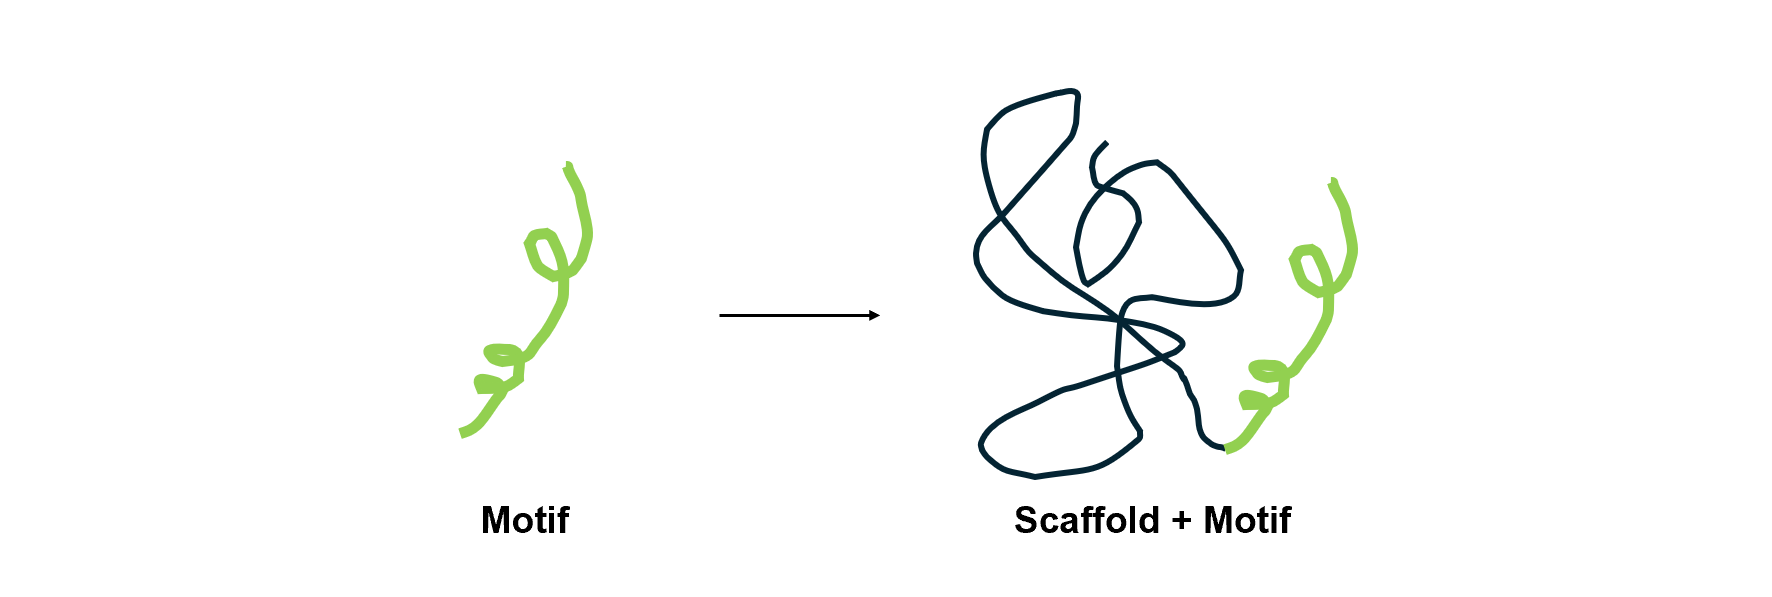

For example, `contigs='A163-181/40'` will take residues 163-181 of Chain A and extend 40 residues on the carboxyl end. Here, A163-181 could be some sort of active or binding site we are trying to stabilize from a larger protein. Knowing this, let's try to do the second task - using diffusion between two scaffold parts.


<font color='#e59454'>**Task Description**</font>

ABLE (PDB ID: [`6w70`](https://www.rcsb.org/structure/6w70)) is a *de novo* protein designed to bind the drug Apixaban. The protein is a helical bundle with four alpha-helicies, which help form a cavity to sequester the target molecule.

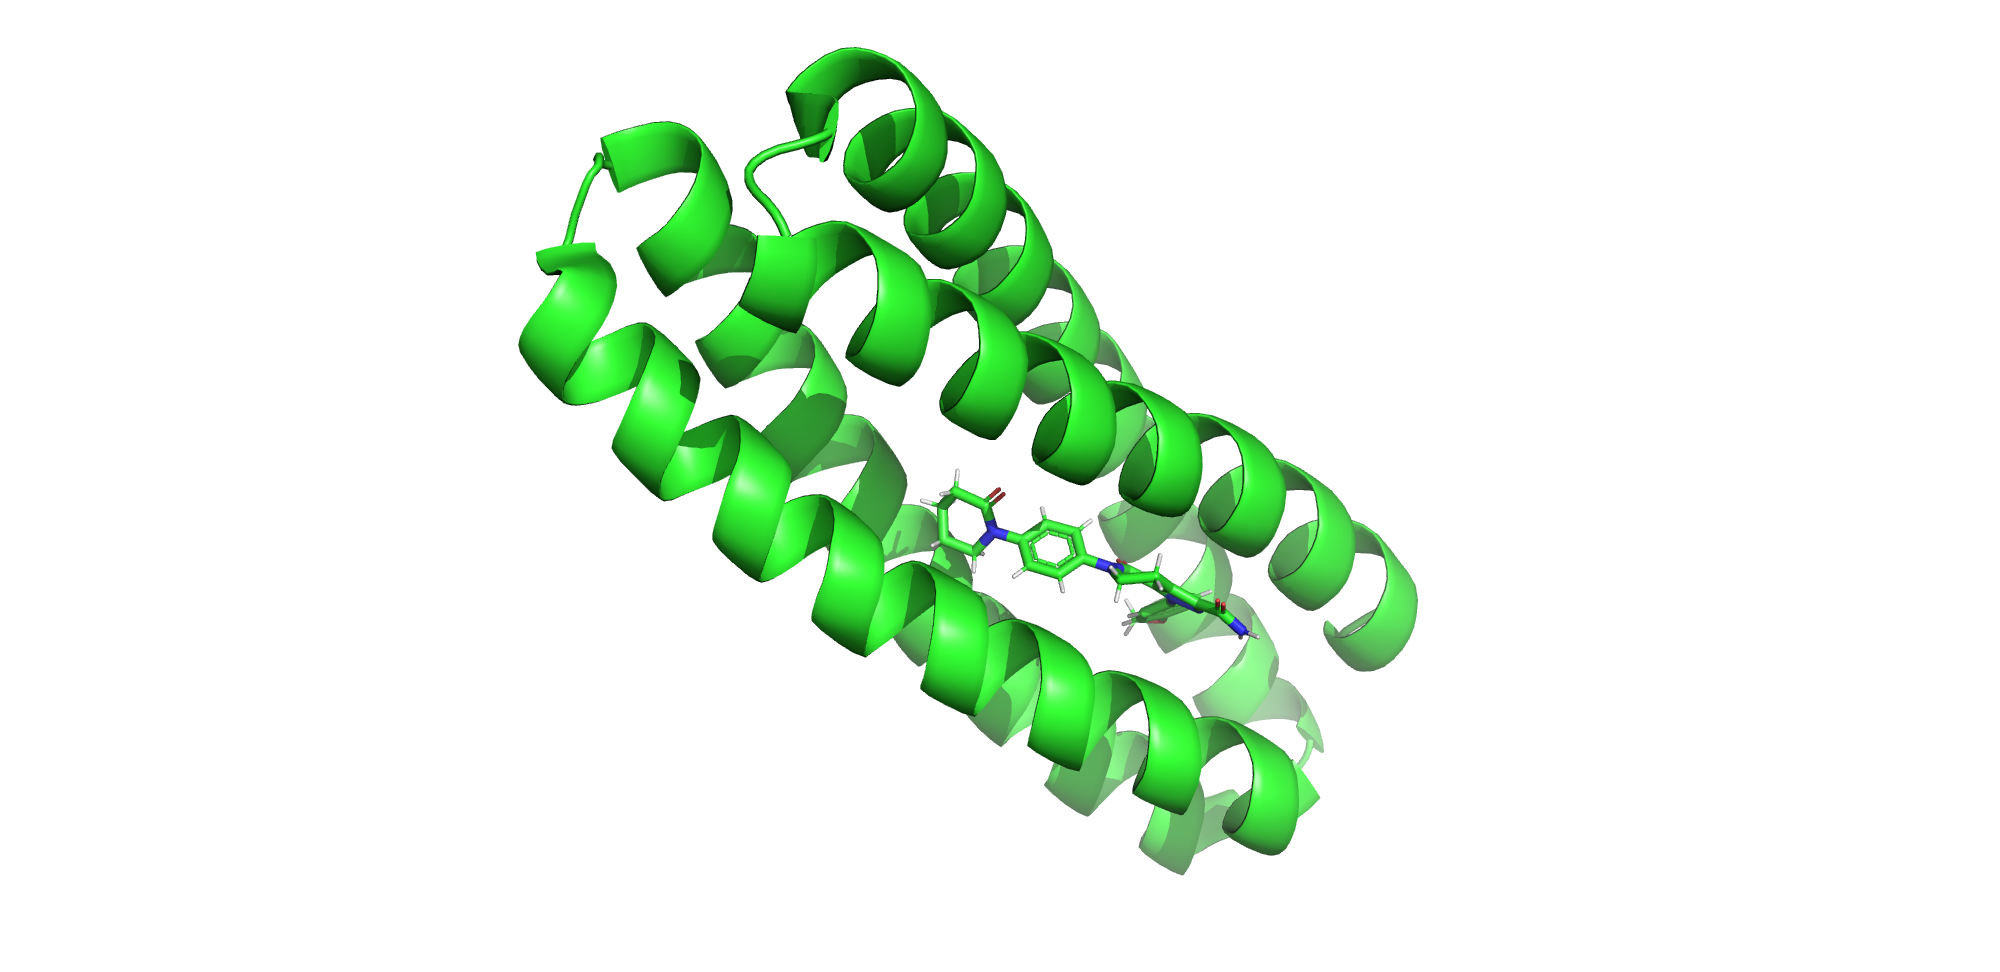


You hear through one of your collegues that there exists a mythical variant called ABLE-D (dimeric ABLE), which has never been imaged before. You are curious about ABLE-D and try to design something similar using our motif scaffolding pipeline.

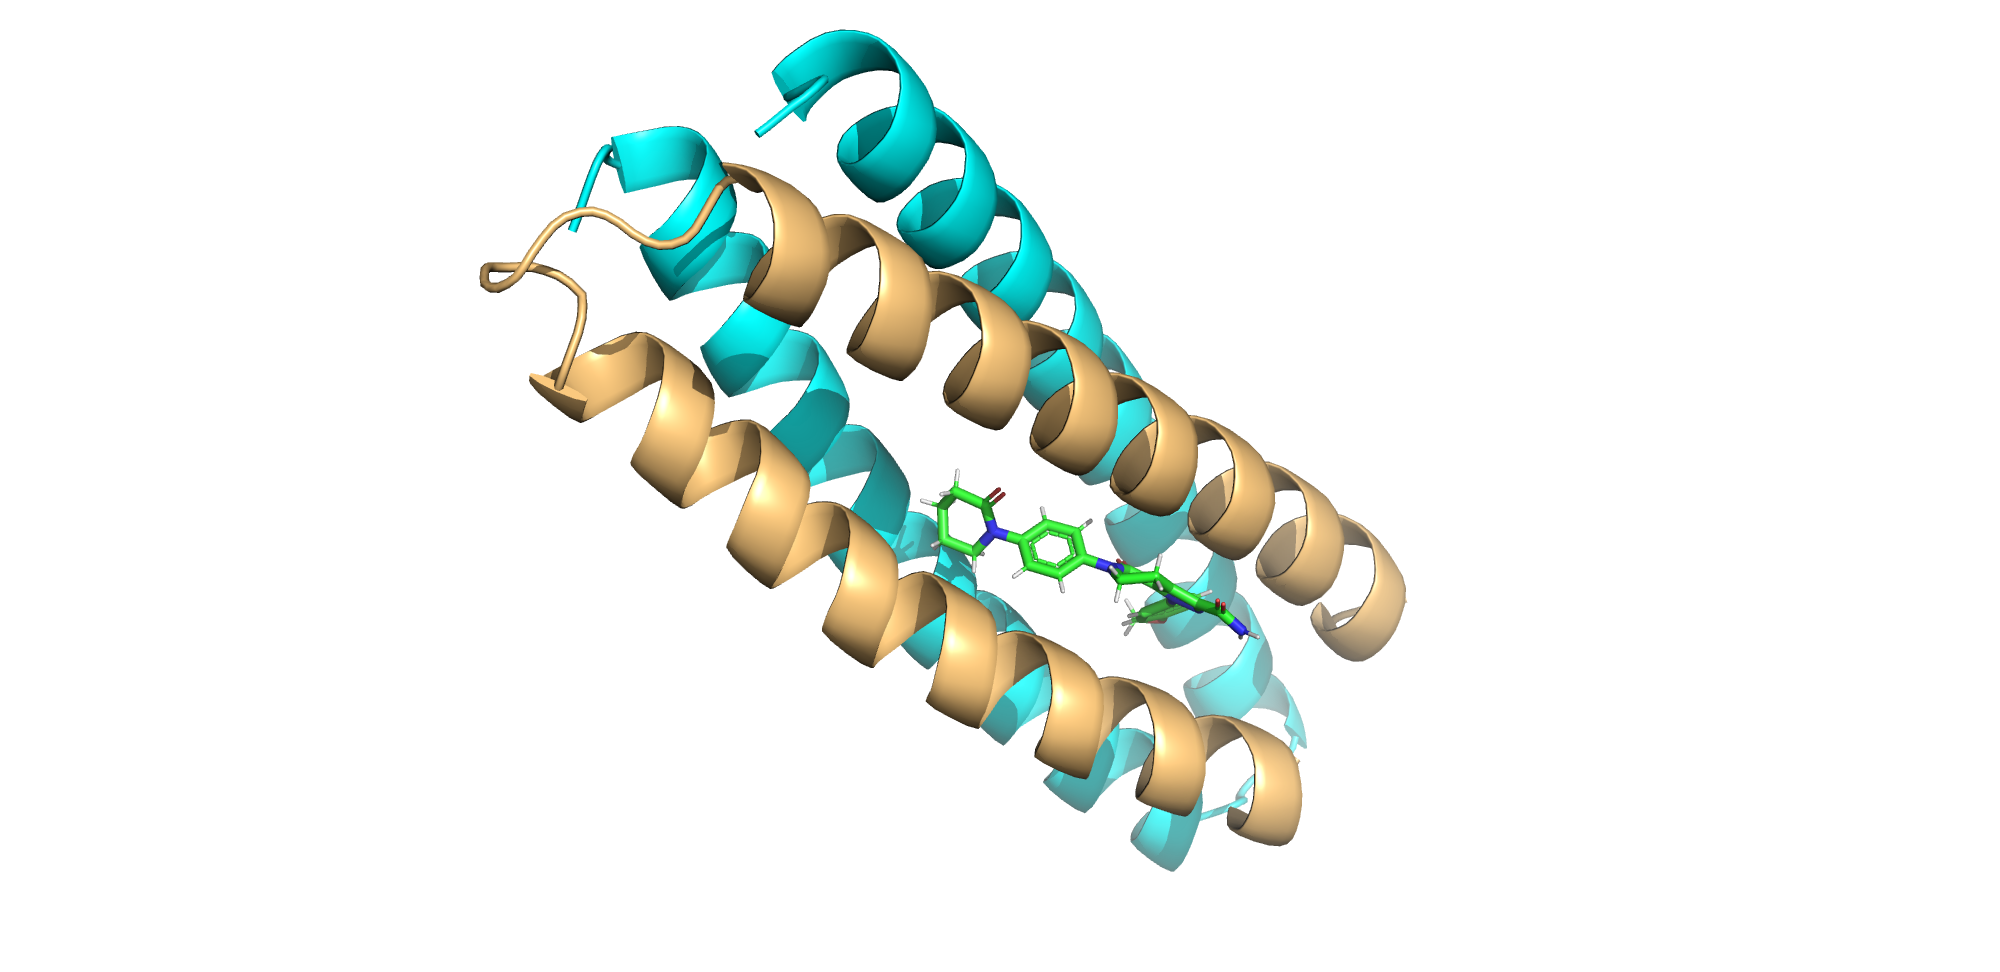

**Keep in mind:**

For `contigs`:
* `:` indicates a chain break
* `/` to defines multiple segments

*If we were running each tool separately, we would also add flags for extra flags for ProteinMPNN to only determine new amino acids for the residues that we diffuse. This is automatically accounted for in our pipeline, so the only flags you will have to play with are for RFDiffusion!*

Note: You may have to download the PDB file and play around to find the correct residues.

In [ ]:
#@markdown Run to show 6w70
view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
path = get_pdb("6w70")
pdb_str = open(path,'r').read()
view.addModel(pdb_str,'pdb',{'hbondCutoff':4.0})
view.setStyle({"model":0},{'cartoon':{'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':100}}})
view.zoomTo()
view.show()

In [ ]:
%%time
#@title Run Motif Scaffolding Pipeline
#@markdown Run **RFdiffusion** to generate a linker between two helicies of ABLE and leave the other two connected. Remember to indicate that both proteins are present in the contigs line.
name = "motif"
contigs = "A1-29/30-126" #@param {type:"string"}
pdb = "6W70" #@param {type:"string"}
iterations = 25 #@param ["25", "50", "100", "150", "200"] {type:"raw"}
hotspot = ""
num_designs = 1
visual = "interactive"
symmetry = "none"
order = 1
chains = ""
add_potential = True
partial_T = "auto"
use_beta_model = False

# determine where to save
path = name
while os.path.exists(f"outputs/{path}_0.pdb"):
  path = name + "_" + ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))

flags = {"contigs":contigs,
         "pdb":pdb,
         "order":order,
         "iterations":iterations,
         "symmetry":symmetry,
         "hotspot":hotspot,
         "path":path,
         "chains":chains,
         "add_potential":add_potential,
         "num_designs":num_designs,
         "use_beta_model":use_beta_model,
         "visual":visual,
         "partial_T":partial_T}

for k,v in flags.items():
  if isinstance(v,str):
    flags[k] = v.replace("'","").replace('"','')
print("RUNNING RFDIFFUSION")
contigs, copies = run_diffusion(**flags)


In [ ]:
# Run Protein MPNN and Alphafold

#@markdown Run **ProteinMPNN** to generate a sequence.
num_seqs = 1 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
mpnn_sampling_temp = 0.1 #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5", "1.0"] {type:"raw"}
rm_aa = "C"
use_solubleMPNN = False

#@markdown Run **AlphaFold** to validate.
num_recycles = 2 #@param ["0", "1", "2", "3", "6", "12"] {type:"raw"}
use_multimer = False

if not os.path.isfile("params/done.txt"):
  print("downloading AlphaFold params...")
  while not os.path.isfile("params/done.txt"):
    time.sleep(5)

contigs_str = ":".join(contigs)
opts = [f"--pdb=outputs/{path}_0.pdb",
        f"--loc=outputs/{path}",
        f"--contig={contigs_str}",
        f"--copies={copies}",
        f"--num_seqs={num_seqs}",
        f"--num_recycles={num_recycles}",
        f"--rm_aa={rm_aa}",
        f"--mpnn_sampling_temp={mpnn_sampling_temp}",
        f"--num_designs={num_designs}"]

if use_multimer: opts.append("--use_multimer")
if use_solubleMPNN: opts.append("--use_soluble")
opts = ' '.join(opts)
!python colabdesign/rf/designability_test.py {opts}

# Show Alphafold output
print("DISPLAYING ALPHAFOLD RESULTS")
if num_designs > 1:
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb_final(change['new'])
  dropdown = widgets.Dropdown(
    options=["best"] + [str(k) for k in range(num_designs)],
    value="best",
    description='design:',
  )
  dropdown.observe(on_change)
  output = widgets.Output()
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb_final(dropdown.value)
else:
  plot_pdb_final()


In [ ]:
#@markdown Stuck? Check examples below for hints. Or run to check your answer.
print("contigs=A1-29/5/A98-126:A30-97")
print("pdb=6W70")

contigs=A1-29/5/A98-126:A30-97
pdb=6W70


# **<font color='#569098'>Section 4: Binder Diffusion</font>**

Our last objective is to use the pipeline to generate a completely new binder. New binders could be used to probe different biological systems by interacting with or tagging other proteins, or potentially be developed into novel therapeutics.

<font color='#e59454'>**Task Description**</font>

Let's pretend that you made ABLE-D in lab, and you found that it doesn't bind Apixaban anymore. Although you are sad that ABLE-D didn't live up to your expectations - you come up with a new idea: what if you can rescue the binding affinity by using another protein to stabilize ABLE-D's binding state?


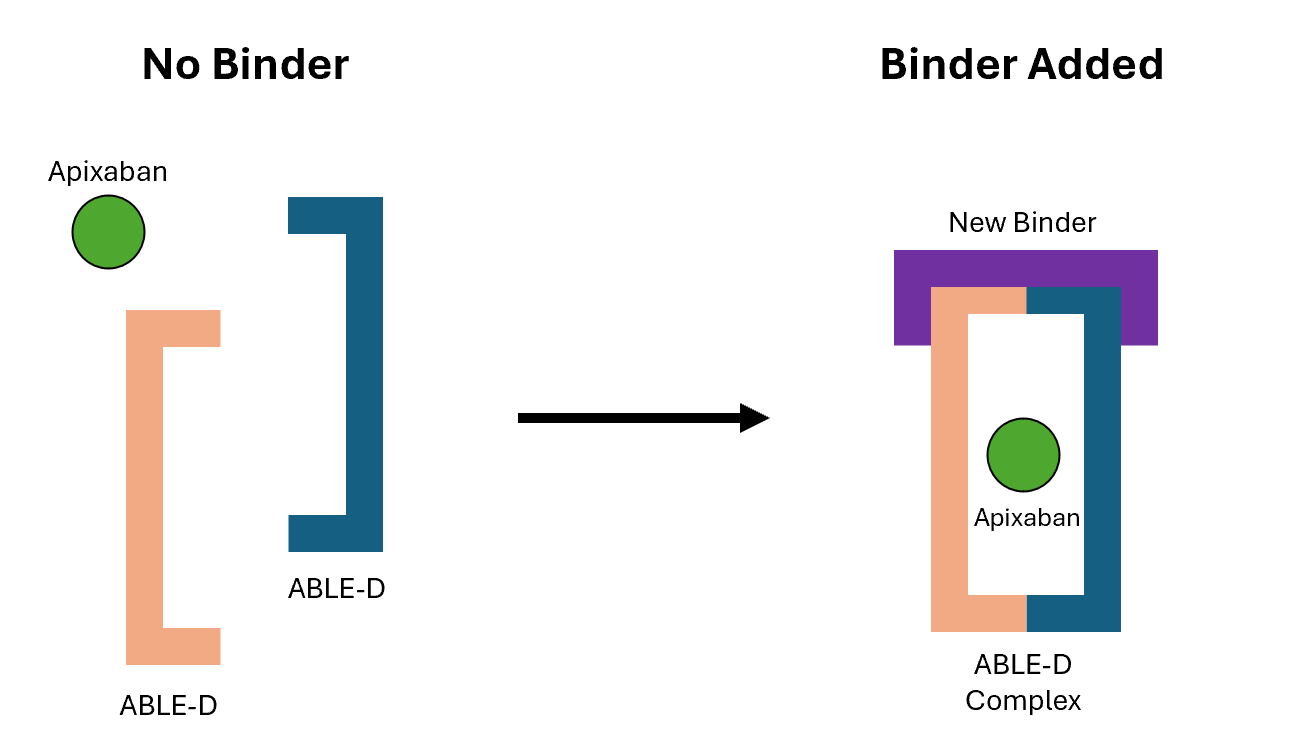

Think about how you might use the pipeline to diffuse such a binder. You will need to edit `contigs` to denote an extra protein of a certain size, and also edit the new `hotspot` flag that has been unhidden to specify possible areas of contact between ABLE-D and the new binder.

As an example, here are the inputs for a binder to an insulin receptor.
contigs='E6-155:70-100' pdb='5KQV' hotspot='E64,E88,E96' - diffuse a binder of length 70 to 100 (sampled randomly) to chain E and defined hotspot(s).

*Note: The pdb is automatically handled for you. But you can download your designs with from `outputs/motif/best.pdb` or `outputs/motif_<code>/best.pdb`and re-upload them by leaving the `pdb` flag and `use_able-d` flags blank*

In [ ]:
%%time
#@title Run Binder Design Pipeline
#@markdown Run **RFdiffusion** to make a binder to the two ABLE-D components. Note: use_able-d will override any pdbs.
name = "binder"
contigs = "A1-63:B1-68:100-100" #@param {type:"string"}
use_able_d = True #@param {type:"boolean"}
if (use_able_d):
  pdb = "/content/outputs/motif/best.pdb"
else:
  pdb = "" #@param {type:"string"}
iterations = 25 #@param ["25", "50", "100", "150", "200"] {type:"raw"}
hotspot = "B58, A41, B56, A44, B5, A22, A26, B8" #@param {type:"string"}
num_designs = 1
visual = "interactive"
symmetry = "none"
order = 1
chains = ""
add_potential = True
partial_T = "auto"
use_beta_model = False

# determine where to save
path = name
while os.path.exists(f"outputs/{path}_0.pdb"):
  path = name + "_" + ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))

flags = {"contigs":contigs,
         "pdb":pdb,
         "order":order,
         "iterations":iterations,
         "symmetry":symmetry,
         "hotspot":hotspot,
         "path":path,
         "chains":chains,
         "add_potential":add_potential,
         "num_designs":num_designs,
         "use_beta_model":use_beta_model,
         "visual":visual,
         "partial_T":partial_T}

for k,v in flags.items():
  if isinstance(v,str):
    flags[k] = v.replace("'","").replace('"','')
print("RUNNING RFDIFFUSION")
contigs, copies = run_diffusion(**flags)


In [ ]:
# Run Protein MPNN and Alphafold

#@markdown Run **ProteinMPNN** to generate a sequence.
num_seqs = 1 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
mpnn_sampling_temp = 0.1 #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5", "1.0"] {type:"raw"}
rm_aa = "C"
use_solubleMPNN = False

#@markdown Run **AlphaFold** to validate.
num_recycles = 2 #@param ["0", "1", "2", "3", "6", "12"] {type:"raw"}
use_multimer = False

if not os.path.isfile("params/done.txt"):
  print("downloading AlphaFold params...")
  while not os.path.isfile("params/done.txt"):
    time.sleep(5)

contigs_str = ":".join(contigs)
opts = [f"--pdb=outputs/{path}_0.pdb",
        f"--loc=outputs/{path}",
        f"--contig={contigs_str}",
        f"--copies={copies}",
        f"--num_seqs={num_seqs}",
        f"--num_recycles={num_recycles}",
        f"--rm_aa={rm_aa}",
        f"--mpnn_sampling_temp={mpnn_sampling_temp}",
        f"--num_designs={num_designs}"]
if use_multimer: opts.append("--use_multimer")
if use_solubleMPNN: opts.append("--use_soluble")
opts = ' '.join(opts)
!python colabdesign/rf/designability_test.py {opts}

# Show Alphafold output
print("DISPLAYING ALPHAFOLD RESULTS")
if num_designs > 1:
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb_final(change['new'])
  dropdown = widgets.Dropdown(
    options=["best"] + [str(k) for k in range(num_designs)],
    value="best",
    description='design:',
  )
  dropdown.observe(on_change)
  output = widgets.Output()
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb_final(dropdown.value)
else:
  plot_pdb_final()


This problem very open-ended (and a bit difficult). There are plenty of ways to specify hotspots, so we will leave it up to you to find one that works! Sometimes, you will need to do a bit of trial and error, so feel free to increase the amount of ProteinMPNN designs, residues, or denoising iterations if your input is correct, but you are having trouble getting the protein to be stable.

## **<font color='#569098'>Conclusion</font>**

At the end of this notebook, you have learned how to make unconditional proteins, generate proteins with scaffolds, and make *de novo* binders to sites of interest. For more advanced or extra topics, such as partial diffusion - visit the full [RFDiffusion notebook](https://colab.research.google.com/github/sokrypton/ColabDesign/blob/v1.1.1/rf/examples/diffusion.ipynb) or take a look at the RFDiffusion-AA notebook for diffusing with ligands and DNA.

After this notebook and all the previous tutorials, you have not only learned how to use deep learning protein design tools, but also learned the theory behind how they work. This is a solid foundation for researching future research, whether it be in tool development or applying protein design to different biological tasks. Good Job!

With that, we wish you good luck in your research and beyond!

-- DL4Proteins Notebooks Team

**Examples and Instructions for the Pipeline**
---
---

Use `contigs` to define continious chains. Use a `:` to define multiple contigs and a `/` to define mutliple segments within a contig.
For example:

**unconditional**
- `contigs='100'` - diffuse **monomer** of length 100
- `contigs='50:100'` - diffuse **hetero-oligomer** of lengths 50 and 100

**motif scaffolding**
 - `contigs='40/A163-181/40'` `pdb='5TPN'`
 - `contigs='A3-30/36/A33-68'` `pdb='6MRR'` - diffuse a loop of length 36 between two segments of defined PDB ranges.


**binder design**
- `contigs='A:50'` `pdb='4N5T'` - diffuse a **binder** of length 50 to chain A of defined PDB.
- `contigs='E6-155:70-100'` `pdb='5KQV'` `hotspot='E64,E88,E96'` - diffuse a **binder** of length 70 to 100 (sampled randomly) to chain E and defined hotspot(s).


*hints and tips*
- `pdb=''` leave blank to get an upload prompt
- `contigs='50-100'` use dash to specify a range of lengths to sample from

*example solutions*

Unconditional Diffusion: `contigs='100'`,`iterations=any`

Motif Scaffolding: `contigs='A1-29/5-5/A98-126 : A30-97'`, `pdb=6w70`, `iterations=any`

Binder: `contigs='A1-63:B1-68:100-100'`, `hotspots=B58, A41, B56, A44`